In [36]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")


In [2]:
# Load data

path = "."
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

print (train.shape, test.shape)

(7613, 5) (3263, 4)


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

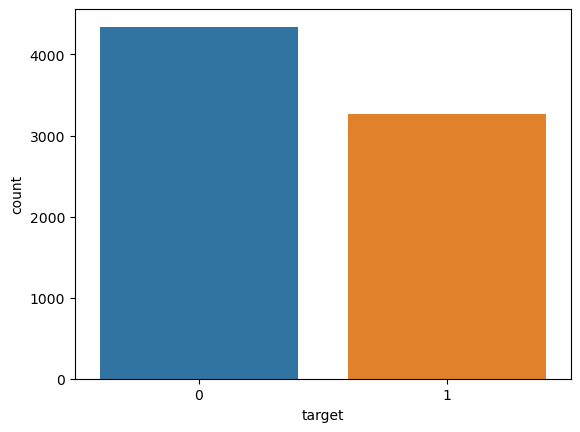

In [6]:
sns.countplot(train["target"])

### 1. Data Visualization - EDA Analysis

#### 1.1 Most common words

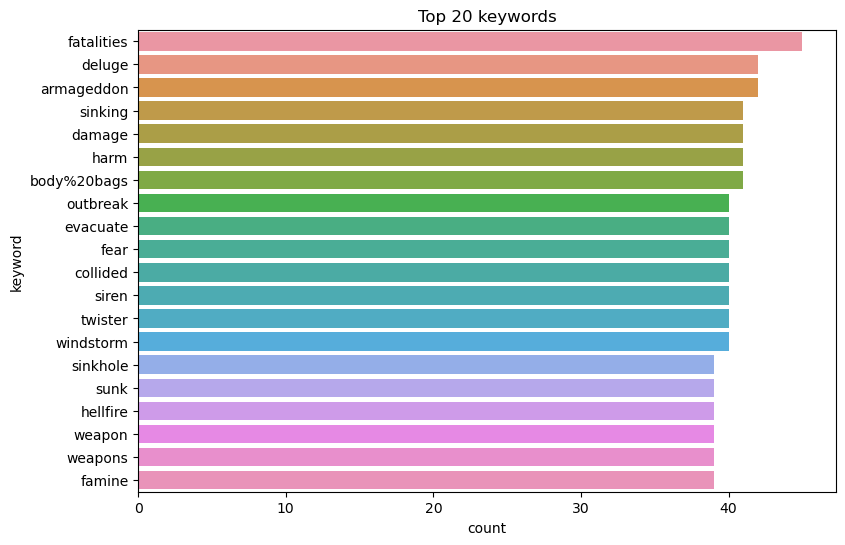

In [7]:
plt.figure(figsize = (9,6))
sns.countplot(y = train.keyword, order = train.keyword.value_counts().iloc[:20].index)
plt.title("Top 20 keywords")
plt.show()

#### 1.2 Top  words in disaster and non-disaster tweets

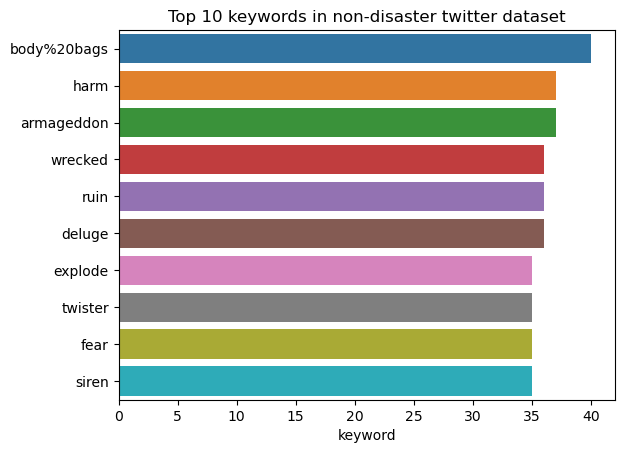

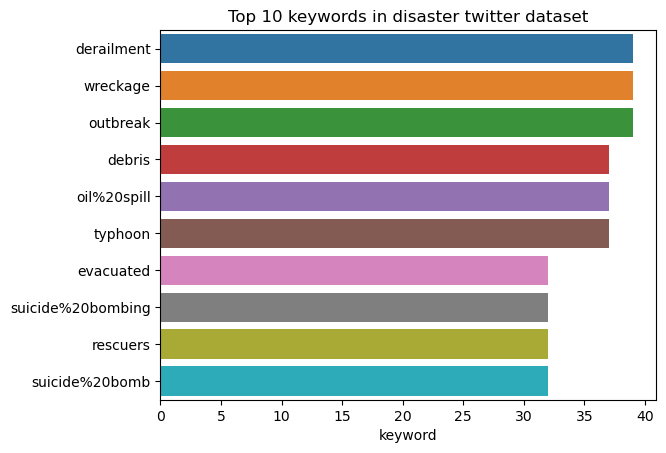

In [8]:
train_nd_kw = train[train.target==0].keyword.value_counts().head(10)
train_d_kw = train[train.target==1].keyword.value_counts().head(10)

sns.barplot(train_nd_kw, train_nd_kw.index)
plt.title("Top 10 keywords in non-disaster twitter dataset")
plt.show()

sns.barplot(train_d_kw, train_d_kw.index)
plt.title("Top 10 keywords in disaster twitter dataset")
plt.show()

#### 1.3 Most common locations in real disaster twitter dataset

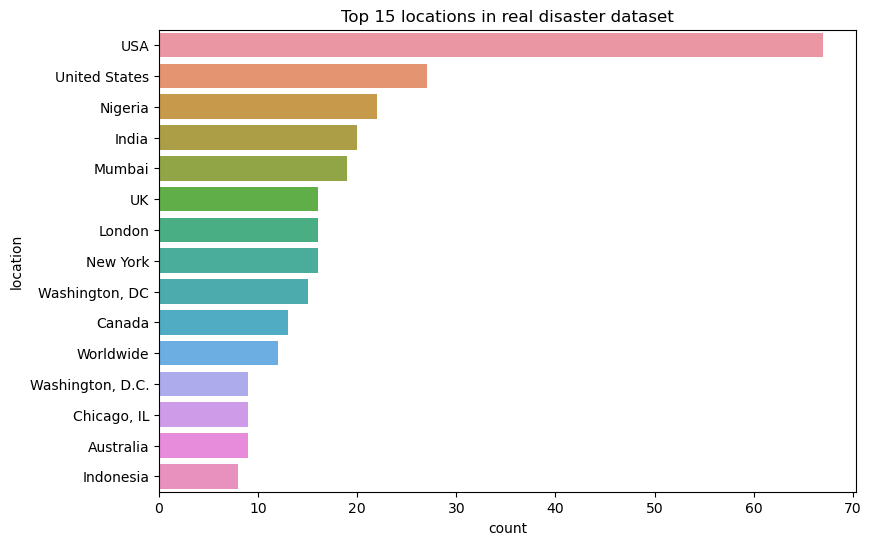

In [9]:
train_d = train[train.target==1]

plt.figure(figsize=(9,6))
sns.countplot(y=train_d.location, order = train_d.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations in real disaster dataset')
plt.show()

#### 1.4 Most common locations in not real disaster twitter dataset

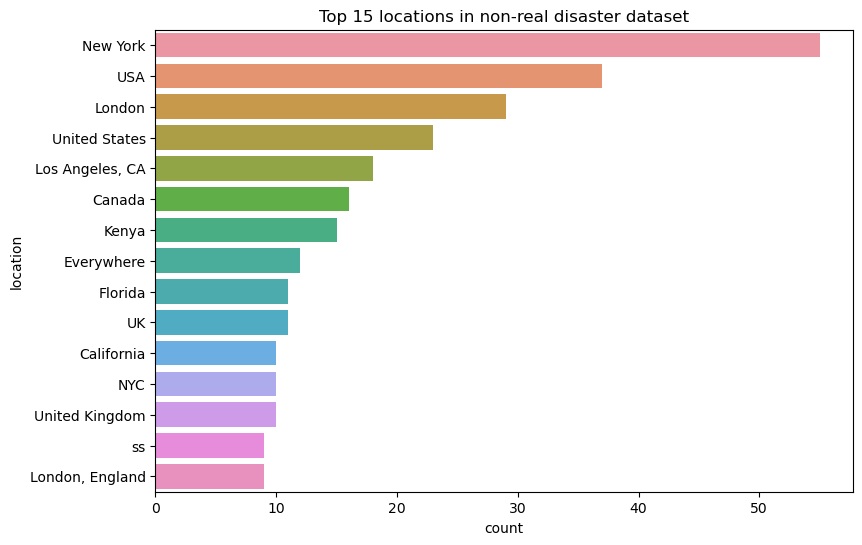

In [10]:
train_n = train[train.target==0]

plt.figure(figsize=(9,6))
sns.countplot(y=train_n.location, order = train_n.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations in non-real disaster dataset')
plt.show()

### 2. FEATURE ENGINEERING AND DATA CLEANING

In [11]:
#!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org wordcloud

In [12]:
import re
from wordcloud import STOPWORDS


In [13]:
def clean_text(text):
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # remove links
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub('\s+', ' ', text).strip()  # Remove  extra spaces
    return text

def finding_hashtags(tweet):
    return " ".join(re.findall(r"#(\w+)", tweet)) or 'no'

def finding_mentions(tweet):
    return " ".join(re.findall(r"@(\w+)", tweet)) or 'no'

def finding_links(tweet):
    return " ".join(re.findall(r"https?://\S+", tweet)) or 'no'

def all_processing_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(finding_hashtags)
    df['mentions'] = df['text'].apply(finding_mentions)
    df['links'] = df['text'].apply(finding_links)
    
    return df


sample_str = train.loc[321, 'text']
print(sample_str)
print(clean_text(sample_str))

train = all_processing_text(train)
test = all_processing_text(test)

Armageddon https://t.co/uCSUDk3q1d
Armageddon


In [43]:
import pandas as pd
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree



# Function to extract locations from text
def extract_locations(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    locations = []
    current_chunk = []
    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == 'GPE':
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in locations:
                locations.append(named_entity)
                current_chunk = []
        else:
            continue
    return locations

# Apply the function to the text column and create a new column for locations
train['locations'] = train['text_clean'].apply(extract_locations)

# Display the DataFrame with the new locations column
train

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,...,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9,locations
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,...,emergency,burning,just,amp,new,bomb,army,going,time,[]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[Forest]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,...,year,hiroshima,man,years,new,day,wreck,atomic,ûªs,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,...,california,body,love,news,people,suicide,gt,û_,wildfire,[]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[Ruby]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,no,no,http://t.co/STfMbbZFB5,60,...,california,body,love,news,people,suicide,gt,û_,wildfire,[]
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,no,aria_ahrary TheTawniest,no,125,...,california,body,love,news,people,suicide,gt,û_,wildfire,"[California, Northern]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,no,no,http://t.co/zDtoyd8EbJ,42,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[]
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,no,no,no,137,...,like,don,police,people,just,let,know,want,think,[Little Portugal]


In [45]:
train.tail(20)

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,...,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9,locations
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0,I just heard a really loud bang and everyone i...,no,no,no,60,...,california,body,love,news,people,suicide,gt,û_,wildfire,[]
7594,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1,A gas thing just exploded and I heard screams ...,no,no,no,91,...,california,body,love,news,people,suicide,gt,û_,wildfire,[]
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby ...,1,NWS: Flash Flood Warning Continued for Shelby ...,tnwx,no,http://t.co/nZ7ACKRrJi,84,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[]
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1,RT @LivingSafely: #NWS issues Severe #Thunders...,NWS Thunderstorm AR NC OK,LivingSafely,http://t.co/FWqfCKNCQW,111,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[]
7597,10852,NaN,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1,#??? #?? #??? #??? MH370: Aircraft debris foun...,no,no,http://t.co/5B7qT2YxdA,99,...,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires,[Malaysia Airlines]
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1,Father-of-three Lost Control of Car After Over...,BathAndNorthEastSomerset,no,http://t.co/fa3FcnlN86,91,...,like,don,police,people,just,let,know,want,think,[Collided]
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1,1.3 #Earthquake in 9Km Ssw Of Anza California ...,Earthquake iPhone,no,http://t.co/V3aZWOAmzK,108,...,like,don,police,people,just,let,know,want,think,[]
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1,Evacuation order lifted for town of Roosevelt:,no,no,http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,46,...,emergency,burning,just,amp,new,bomb,army,going,time,"[Evacuation, Roosevelt]"
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,#breaking #LA Refugio oil spill may have been ...,breaking LA,no,http://t.co/5ueCmcv2Pk,76,...,year,hiroshima,man,years,new,day,wreck,atomic,ûªs,[]
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1,a siren just went off and it wasn't the Forney...,no,no,no,65,...,emergency,burning,just,amp,new,bomb,army,going,time,[]


In [15]:
test

,id,keyword,location,text,text_clean,hashtags,mentions,links
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,no,no,no
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",earthquake,no,no
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...",no,no,no
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,Spokane wildfires,no,no
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,no,no,no
...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,no,no,no
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My city...,no,no,no
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago,no,no,http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO),no,no,http://t.co/3X6RBQJHn3


In [16]:
train

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,no,no,http://t.co/STfMbbZFB5
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,no,aria_ahrary TheTawniest,no
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,no,no,http://t.co/zDtoyd8EbJ
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,no,no,no


In [17]:
def feature_generation(df):
    
    df["text_len"] = df["text_clean"].astype(str).apply(len)  # -> length of tweet
    df["ratio_of_capital_letters"] =  df["text_clean"].apply(lambda x: sum(1 for c in str(x) if c.isupper())) / df["text_len"]
    df['number_of_words'] = df["text_clean"].apply(lambda x: len(str(x).split()))  
    df["number_of_characters"] = df["text_clean"].apply(lambda x: len(str(x)))
    df["number_of_stopwords"] = df["text_clean"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df["number_of_punctuation"] = df["text_clean"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df["number_of_hashtags"] = df["hashtags"].apply(lambda x: len(str(x).split()) if x != "no" else 0)
    df["number_of_mentions"] = df["mentions"].apply(lambda x: len(str(x).split()) if x != "no" else 0)
    df["number_of_links"] = df["links"].apply(lambda x: len(str(x).split()) if x != "no" else 0)
    
    return df

In [18]:
train_full = feature_generation(train)
test_full = feature_generation(test)

print(train_full.shape, test_full.shape)

(7613, 18) (3263, 17)


In [41]:
X = vectorizer.fit_transform(train_full['text_clean'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Function to get top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[f"topic_{topic_idx}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return top_words

# Get top words for each topic
n_top_words = 5
feature_names = vectorizer.get_feature_names_out()
top_words = get_top_words(lda, feature_names, n_top_words)

print("Top words for each topic:")
for topic, words in top_words.items():
    print(f"{topic}: {', '.join(words)}")

# Assign topics to tweets based on the highest topic probability
topic_distribution = lda.transform(X)
train['dominant_topic'] = topic_distribution.argmax(axis=1)

# Add top words of the dominant topic as features
for i in range(n_top_words):
    train[f'topic_word_{i}'] = train['dominant_topic'].apply(lambda topic: top_words[f'topic_{topic}'][i])

train

Top words for each topic:
topic_0: just, california, body, love, news
topic_1: û_, year, hiroshima, man, years
topic_2: amp, like, don, police, people
topic_3: disaster, nuclear, families, video, youtube
topic_4: buildings, emergency, burning, just, amp


,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,...,topic_word_0,topic_word_1,topic_word_2,topic_word_3,topic_word_4,topic_word_5,topic_word_6,topic_word_7,topic_word_8,topic_word_9
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,...,buildings,emergency,burning,just,amp,new,bomb,army,going,time
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,...,disaster,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,...,û_,year,hiroshima,man,years,new,day,wreck,atomic,ûªs
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,...,just,california,body,love,news,people,suicide,gt,û_,wildfire
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,...,disaster,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,no,no,http://t.co/STfMbbZFB5,60,...,just,california,body,love,news,people,suicide,gt,û_,wildfire
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,no,aria_ahrary TheTawniest,no,125,...,just,california,body,love,news,people,suicide,gt,û_,wildfire
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,no,no,http://t.co/zDtoyd8EbJ,42,...,disaster,nuclear,families,video,youtube,û_,mh370,crash,obama,legionnaires
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,no,no,no,137,...,amp,like,don,police,people,just,let,know,want,think


In [20]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_full["text"][0:1])
print(train_full["text"][0:1].values)
print(example_train_vectors)
print(count_vectorizer.get_feature_names())
print(count_vectorizer.vocabulary_)


['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
  (0, 8)	1
  (0, 3)	1
  (0, 2)	1
  (0, 10)	1
  (0, 9)	1
  (0, 7)	1
  (0, 11)	1
  (0, 4)	1
  (0, 6)	1
  (0, 1)	1
  (0, 5)	1
  (0, 12)	1
  (0, 0)	1
['all', 'allah', 'are', 'deeds', 'earthquake', 'forgive', 'may', 'of', 'our', 'reason', 'the', 'this', 'us']
{'our': 8, 'deeds': 3, 'are': 2, 'the': 10, 'reason': 9, 'of': 7, 'this': 11, 'earthquake': 4, 'may': 6, 'allah': 1, 'forgive': 5, 'us': 12, 'all': 0}


In [21]:
train_full.corr()

,id,target,text_len,ratio_of_capital_letters,number_of_words,number_of_characters,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links
id,1.000000,0.060781,0.011613,-0.014618,0.004557,0.011613,0.015497,-0.007101,0.000294,-0.030020,0.013063
target,0.060781,1.000000,0.096527,-0.014983,0.017243,0.096527,-0.111250,-0.012545,0.051633,-0.102692,0.195678
text_len,0.011613,0.096527,1.000000,-0.128066,0.923295,1.000000,0.612260,0.386259,0.132795,0.166980,-0.162911
ratio_of_capital_letters,-0.014618,-0.014983,-0.128066,1.000000,-0.148890,-0.128066,-0.234512,0.026821,0.054894,-0.000137,0.165138
number_of_words,0.004557,0.017243,0.923295,-0.148890,1.000000,0.923295,0.784580,0.272832,0.024078,0.068006,-0.233699
number_of_characters,0.011613,0.096527,1.000000,-0.128066,0.923295,1.000000,0.612260,0.386259,0.132795,0.166980,-0.162911
number_of_stopwords,0.015497,-0.111250,0.612260,-0.234512,0.784580,0.612260,1.000000,0.062786,-0.126131,0.061313,-0.411663
number_of_punctuation,-0.007101,-0.012545,0.386259,0.026821,0.272832,0.386259,0.062786,1.000000,0.311118,0.233381,-0.053329
number_of_hashtags,0.000294,0.051633,0.132795,0.054894,0.024078,0.132795,-0.126131,0.311118,1.000000,-0.044634,0.174423
number_of_mentions,-0.030020,-0.102692,0.166980,-0.000137,0.068006,0.166980,0.061313,0.233381,-0.044634,1.000000,-0.223640


In [22]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7613 non-null   int64  
 1   keyword                   7552 non-null   object 
 2   location                  5080 non-null   object 
 3   text                      7613 non-null   object 
 4   target                    7613 non-null   int64  
 5   text_clean                7613 non-null   object 
 6   hashtags                  7613 non-null   object 
 7   mentions                  7613 non-null   object 
 8   links                     7613 non-null   object 
 9   text_len                  7613 non-null   int64  
 10  ratio_of_capital_letters  7613 non-null   float64
 11  number_of_words           7613 non-null   int64  
 12  number_of_characters      7613 non-null   int64  
 13  number_of_stopwords       7613 non-null   int64  
 14  number_o

### 3. WORD ENCODING AND VECTORIZATION

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import sparse

In [24]:
X_train_full = train_full[['text_len', 'ratio_of_capital_letters', 'number_of_words', 'number_of_characters',
                           'number_of_stopwords', 'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                           'number_of_links']].values
X_test_full = test_full[['text_len', 'ratio_of_capital_letters', 'number_of_words', 'number_of_characters',
                         'number_of_stopwords', 'number_of_punctuation', 'number_of_hashtags', 'number_of_mentions',
                         'number_of_links']].values


# Define target variable
y_train = train_full['target']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train, test_size=0.2, random_state=42)


Training Logistic Regression...
Accuracy for Logistic Regression: 0.6539724228496389
Training Random Forest...
Accuracy for Random Forest: 0.7045305318450427
Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.6894287590282338
Training SVM...
Accuracy for SVM: 0.6283650689428759
Training Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes: 0.6552856204858831


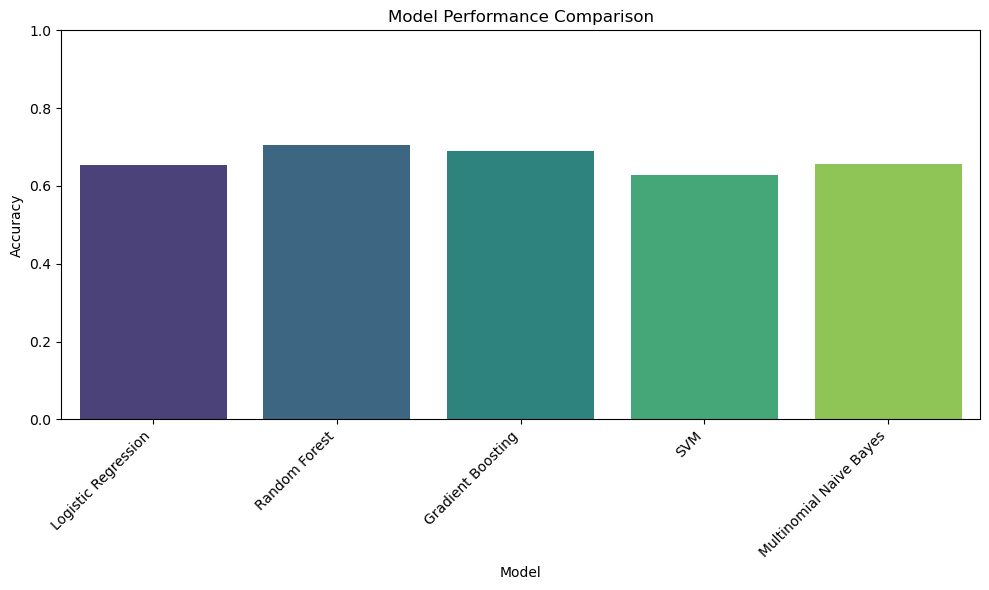

In [25]:

# Create a pipeline for each model (without vectorizer)
models = {
    "Logistic Regression": Pipeline([
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('clf', SVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ('clf', MultinomialNB())
    ])
}


# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    results.append({"Model": name, "Accuracy": accuracy})

# Plotting the results
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()



Training Logistic Regression...
Accuracy for Logistic Regression: 0.8056467498358503
Training Random Forest...
Accuracy for Random Forest: 0.7951411687458962
Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.7465528562048588
Training SVM...
Accuracy for SVM: 0.8089297439264609
Training Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes: 0.8036769533814839


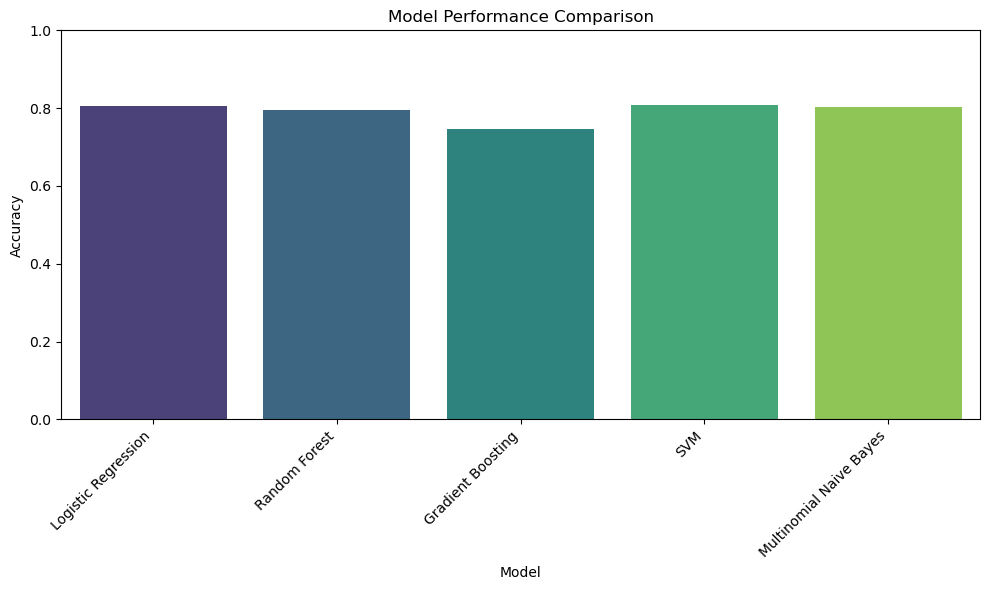

In [26]:
# Create a pipeline for each model by using vectorizer (tf-idf)
models = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', SVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', MultinomialNB())
    ])
}

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_full['text_clean'], train_full['target'], test_size=0.2, random_state=42)

# Train and evaluate each model
results2 = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    results2.append({"Model": name, "Accuracy": accuracy})

# Plotting the results
results_df2 = pd.DataFrame(results2)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df2, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


# Model Comparision

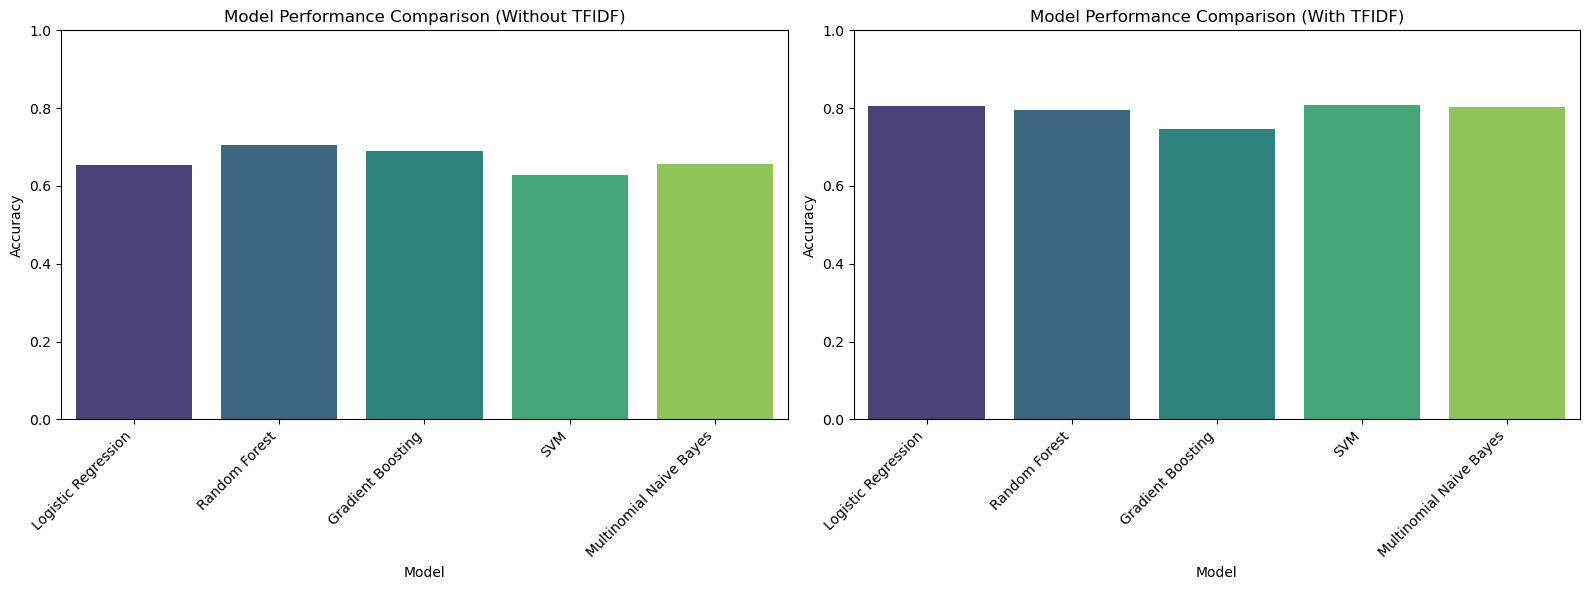

In [27]:
# Rename the 'Accuracy' column in results_df
results_df.rename(columns={'Accuracy': 'Accuracy_without_TFIDF'}, inplace=True)

# Merge the two results dataframes
merged_results = pd.concat([results_df, results_df2.rename(columns={'Accuracy': 'Accuracy_with_TFIDF'})['Accuracy_with_TFIDF']], axis=1)

# Plotting the results side by side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy_without_TFIDF', data=merged_results, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model Performance Comparison (Without TFIDF)')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Accuracy_with_TFIDF', data=merged_results, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model Performance Comparison (With TFIDF)')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()



In [31]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org  transformers

     ---------------------------------------- 9.1/9.1 MB 235.4 kB/s eta 0:00:00
     -------------------------------------- 287.9/287.9 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 353.7 kB/s eta 0:00:00
     ------------------------------------ 401.2/401.2 kB 104.3 kB/s eta 0:00:00
     ------------------------------------- 316.1/316.1 kB 75.6 kB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1


In [34]:
from transformers import pipeline



In [35]:

# Load pre-trained sentiment-analysis pipeline
classifier = pipeline('zero-shot-classification')

# Define candidate labels (categories)
candidate_labels = ['medical needs', 'food and water', 'shelter', 'information', 'emotional support']

# Classify each tweet
train['category'] = train['text_clean'].apply(
    lambda x: classifier(x, candidate_labels)['labels'][0]
)



# Filter relevant tweets
relevant_tweets = train[train['target'] == 1]

# Display categorized relevant tweets
print(relevant_tweets[['id', 'text', 'category']])

No model was supplied, defaulted to FacebookAI/roberta-large-mnli and revision 130fb28 (https://huggingface.co/FacebookAI/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /FacebookAI/roberta-large-mnli/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))"), '(Request ID: dd2d0739-bcba-4b8c-8a2c-65a638f77367)')

In [28]:
train

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,ratio_of_capital_letters,number_of_words,number_of_characters,number_of_stopwords,number_of_punctuation,number_of_hashtags,number_of_mentions,number_of_links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,0.144928,13,69,6,1,1,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,0.131579,7,38,0,1,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,0.015038,22,133,11,3,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,0.015625,8,64,1,2,1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,0.034483,16,87,7,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,no,no,http://t.co/STfMbbZFB5,60,0.016667,10,60,2,0,0,0,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,no,aria_ahrary TheTawniest,no,125,0.048000,20,125,9,5,0,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,no,no,http://t.co/zDtoyd8EbJ,42,0.166667,7,42,1,6,0,0,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,no,no,no,137,0.029197,19,137,5,5,0,0,0


Training Logistic Regression...
Accuracy for Logistic Regression: 0.8076165462902167
Training Random Forest...
Accuracy for Random Forest: 0.793827971109652
Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.7544320420223244
Training SVM...
Accuracy for SVM: 0.8076165462902167
Training Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes: 0.8056467498358503


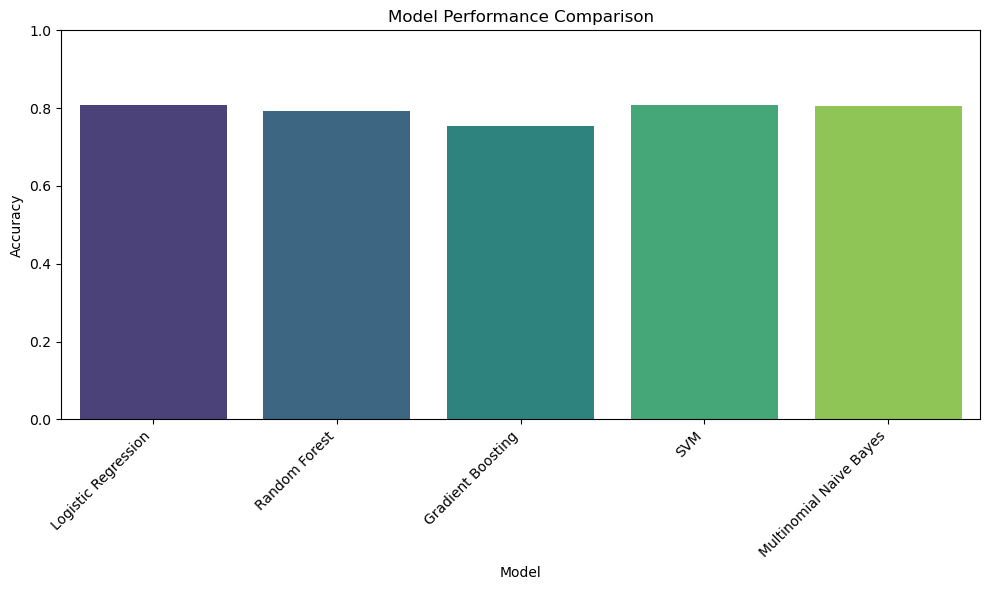

In [80]:
# Create a pipeline for each model by using vectorizer (CountVectorizer)
models = {
    "Logistic Regression": Pipeline([
        ('count_vectorizer', CountVectorizer()),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
         ('count_vectorizer', CountVectorizer()),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('count_vectorizer', CountVectorizer()),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
       ('count_vectorizer', CountVectorizer()),
        ('clf', SVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ('count_vectorizer', CountVectorizer()),
        ('clf', MultinomialNB())
    ])
}

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_full['text_clean'], train_full['target'], test_size=0.2, random_state=42)

# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    results.append({"Model": name, "Accuracy": accuracy})

# Plotting the results
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


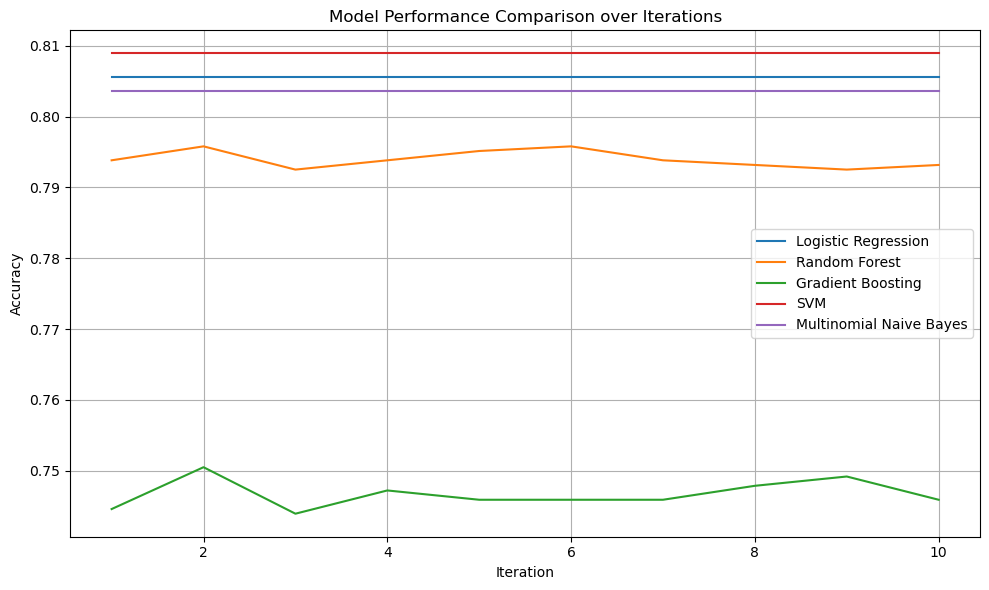

In [46]:


# Create a pipeline for each model
models = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', RandomForestClassifier())
    ]),
    "Gradient Boosting": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', GradientBoostingClassifier())
    ]),
    "SVM": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', SVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', MultinomialNB())
    ])
}

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_full['text_clean'], train_full['target'], test_size=0.2, random_state=42)

# Train and evaluate each model
results = {name: [] for name in models}
num_iterations = 10
for _ in range(num_iterations):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        results[name].append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
for name, accuracies in results.items():
    plt.plot(range(1, num_iterations + 1), accuracies, label=name)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison over Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Fill NaN values in text, keyword, and location columns with an empty string
train_full['text_clean'].fillna('', inplace=True)
train_full['keyword'].fillna('', inplace=True)
train_full['location'].fillna('', inplace=True)
test_full['text_clean'].fillna('', inplace=True)
test_full['keyword'].fillna('', inplace=True)
test_full['location'].fillna('', inplace=True)

# Define the ColumnTransformer to handle text and numerical features separately
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'text_clean'),
        ('keyword', CountVectorizer(), 'keyword'),
        ('location', CountVectorizer(), 'location'),
        ('num', StandardScaler(), ['number_of_words', 'number_of_stopwords', 
                                   'number_of_punctuation', 'number_of_hashtags', 
                                   'number_of_mentions', 'number_of_links', 
                                   'ratio_of_capital_letters', 'number_of_characters'])
    ])

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate each model using cross-validation
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    scores = cross_validate(pipeline, train_full[['text_clean', 'keyword', 'location', 
                                                  'number_of_words', 'number_of_stopwords', 
                                                  'number_of_punctuation', 'number_of_hashtags', 
                                                  'number_of_mentions', 'number_of_links', 
                                                  'ratio_of_capital_letters', 'number_of_characters']], 
                            train_full['target'], 
                            cv=5, scoring=scoring)
    results[name] = scores

# Display results
for name, scores in results.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"  Precision: {scores['test_precision'].mean():.4f}")
    print(f"  Recall: {scores['test_recall'].mean():.4f}")
    print(f"  F1 Score: {scores['test_f1_score'].mean():.4f}")


Model: Logistic Regression
  Accuracy: 0.6809
  Precision: 0.6533
  Recall: 0.5644
  F1 Score: 0.6008
Model: Random Forest
  Accuracy: 0.6844
  Precision: 0.7684
  Recall: 0.3904
  F1 Score: 0.5093
Model: SVM
  Accuracy: 0.7226
  Precision: 0.7475
  Recall: 0.5384
  F1 Score: 0.6228
Model: Gradient Boosting
  Accuracy: 0.6700
  Precision: 0.6887
  Recall: 0.4256
  F1 Score: 0.5244


In [77]:

# Fill NaN values in text, keyword, and location columns with an empty string
train_full['text_clean'].fillna('', inplace=True)
train_full['keyword'].fillna('', inplace=True)
train_full['location'].fillna('', inplace=True)
test_full['text_clean'].fillna('', inplace=True)
test_full['keyword'].fillna('', inplace=True)
test_full['location'].fillna('', inplace=True)

# Define the ColumnTransformer to handle text and numerical features separately
preprocessor = ColumnTransformer(
    transformers=[
        ('text_clean', TfidfVectorizer(), 'text_clean'),
        ('keyword', TfidfVectorizer(), 'keyword'),
        ('location', TfidfVectorizer(), 'location'),
        ('num', StandardScaler(), ['number_of_words', 'number_of_stopwords', 
                                   'number_of_punctuation', 'number_of_hashtags', 
                                   'number_of_mentions', 'number_of_links', 
                                   'ratio_of_capital_letters', 'number_of_characters'])
    ])

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate each model using cross-validation
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    scores = cross_validate(pipeline, train_full[['text_clean', 'keyword', 'location', 
                                                  'number_of_words', 'number_of_stopwords', 
                                                  'number_of_punctuation', 'number_of_hashtags', 
                                                  'number_of_mentions', 'number_of_links', 
                                                  'ratio_of_capital_letters', 'number_of_characters']], 
                            train_full['target'], 
                            cv=5, scoring=scoring)
    results[name] = scores

# Display results
for name, scores in results.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"  Precision: {scores['test_precision'].mean():.4f}")
    print(f"  Recall: {scores['test_recall'].mean():.4f}")
    print(f"  F1 Score: {scores['test_f1_score'].mean():.4f}")


Model: Logistic Regression
  Accuracy: 0.6454
  Precision: 0.6037
  Recall: 0.5503
  F1 Score: 0.5673
Model: Random Forest
  Accuracy: 0.6852
  Precision: 0.7589
  Recall: 0.4011
  F1 Score: 0.5186
Model: SVM
  Accuracy: 0.6711
  Precision: 0.6477
  Recall: 0.5210
  F1 Score: 0.5733
Model: Gradient Boosting
  Accuracy: 0.6753
  Precision: 0.6877
  Recall: 0.4522
  F1 Score: 0.5441
